In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# PEP8 Checker
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [3]:
orders = pd.read_csv('data/WRK_orders.csv')
order_items = pd.read_csv('data/WRK_order_items.csv')

In [4]:
def barchart_percent(x, data, figsize, rotation=False):
    # Barchart visualisation
    plt.figure(figsize=figsize)
    ax = sns.countplot(x=x,
                       data=data)
    total = len(data)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
        
    if rotation == True:
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Order_items and order_payments give information on each order. I will try to create new features / order with those information first.

# Order base dataset features engineering

## Order items

In [5]:
# Visualisation of order item dataset
order_items.head()

,order_id,order_item_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP
1,130898c0987d1801452a8ed92a670612,1,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP
2,532ed5e14e24ae1f0d735b91524b98b9,1,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP
3,6f8c31653edb8c83e1a739408b5ff750,1,2017-08-07 18:55:08,58.9,16.17,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP
4,7d19f4ef4d04461989632411b7e588b9,1,2017-08-16 22:05:11,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP


In [6]:
order_items.dtypes

order_id                       object
order_item_id                   int64
shipping_limit_date            object
price                         float64
freight_value                 float64
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
seller_zip_code_prefix          int64
seller_city                    object
seller_state                   object
dtype: object

Total price and total freight value per order have already been calculated during cleaning. I calculated the main order product category using the mode of product category name, the average product name lenght and average product description lenght, the average product photo quantity, the total order volume and weight. 

In [7]:
# Calculate product volume length * height * width
order_items['product_volume_cm3'] = order_items['product_height_cm'] * \
    order_items['product_length_cm'] * order_items['product_width_cm']

In [8]:
# Grouping by order and new features calculation
order_items = order_items.groupby(['order_id']).apply(lambda x: pd.Series({
    'products_category_name': stats.mode(x['product_category_name'])[0].item(),
    'products_name_lenght': x['product_name_lenght'].mean(),
    'products_description_lenght': x['product_description_lenght'].mean(),
    'products_photos_qty': x['product_photos_qty'].mean(),
    'order_tot_weight_g': x['product_weight_g'].sum(),
    'order_tot_volume_cm3': x['product_volume_cm3'].sum(),
}))

In [9]:
# Visualisation of the new dataset
display(order_items.sample(10))
print(order_items.shape)

,products_category_name,products_name_lenght,products_description_lenght,products_photos_qty,order_tot_weight_g,order_tot_volume_cm3
order_id,,,,,,
ca407fb4d0b3cada058f453a973155cc,watches_gifts,56.0,710.0,1.0,550.0,1936.0
619d55679601970d4f11fd01cd162ecd,home_appliances,60.0,1014.0,4.0,150.0,4500.0
484e1ab05a56b8ad354e449200a41742,home_appliances,57.0,1113.0,10.0,12900.0,15625.0
07f970754e737efe221e6349eeb5a8e7,health_beauty,59.0,879.0,1.0,6900.0,17576.0
f8ff2ca85b5c244343205cf7d85904bc,fashion_shoes,57.0,404.0,4.0,1400.0,8712.0
03e533f76e0f8827796f3d0a45c61dc0,electronics,49.0,190.0,1.0,133.0,2772.0
3f63ce07f0fd566885c47bda7ad3c3a6,stationery,58.0,202.0,5.0,8600.0,34800.0
481fc532b3f80d9dea57e91dbbcf7119,furniture_decor,47.0,325.0,6.0,3300.0,28420.0
b31c7dea63bb08f8cdd1ec32514ccf0b,furniture_decor,40.0,284.0,3.0,9300.0,40000.0


(98666, 6)


In [10]:
# Define product category name dytpe as string
order_items['products_category_name'] \
    = order_items['products_category_name'].astype('str')

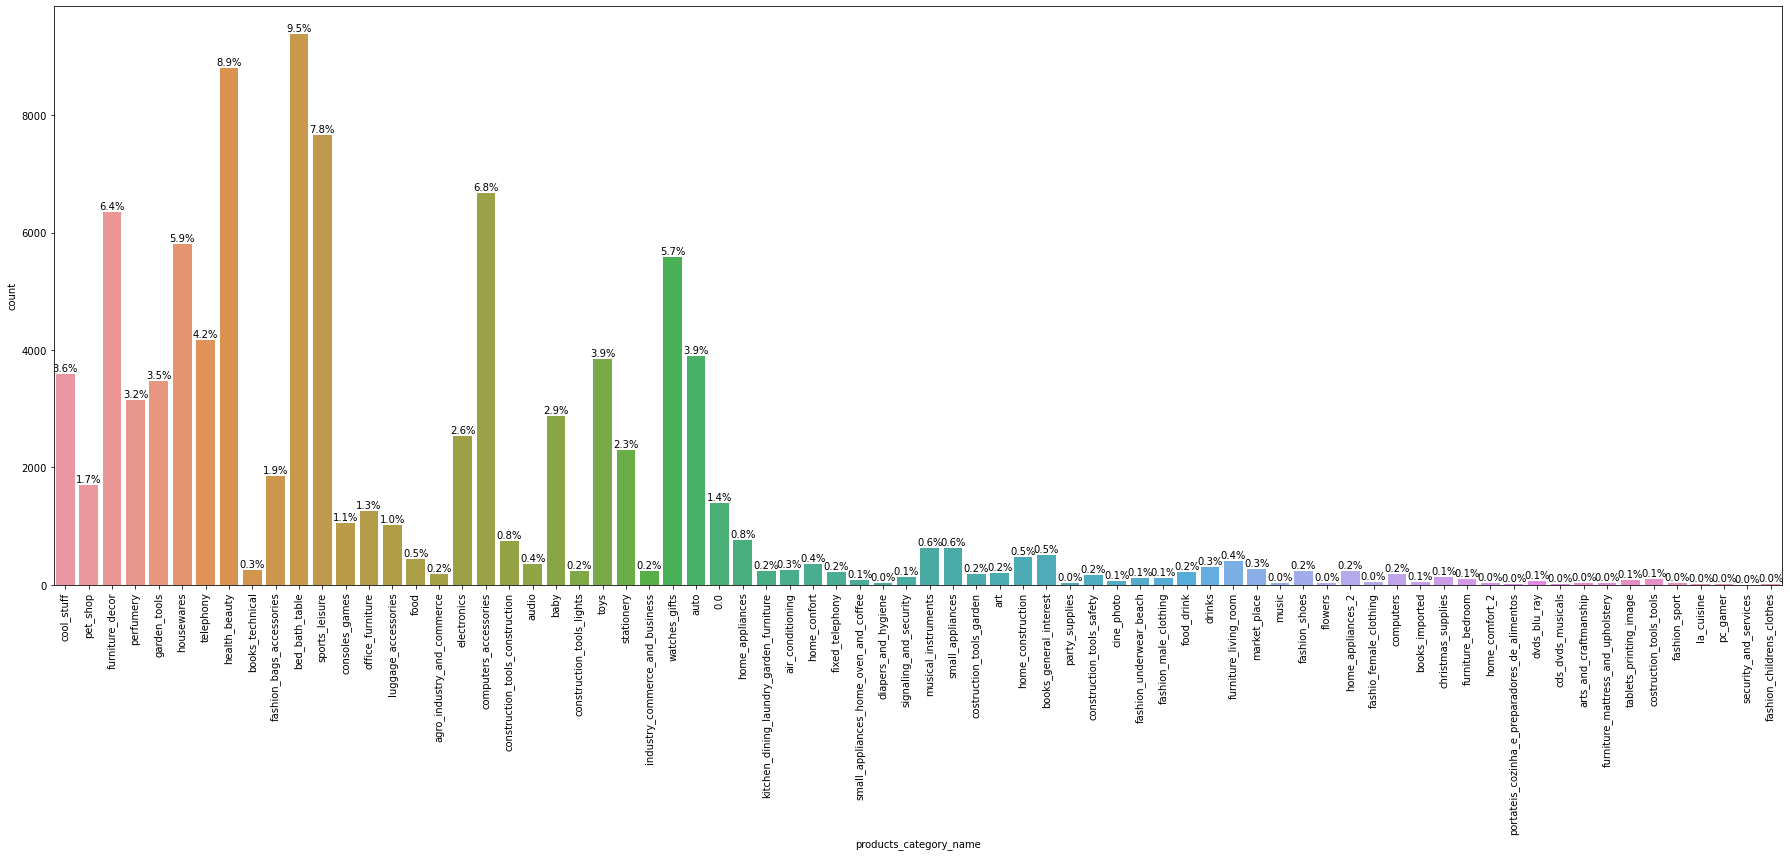

In [11]:
barchart_percent(figsize=(25, 12),
                 x='products_category_name',
                 data=order_items,
                 rotation=True)

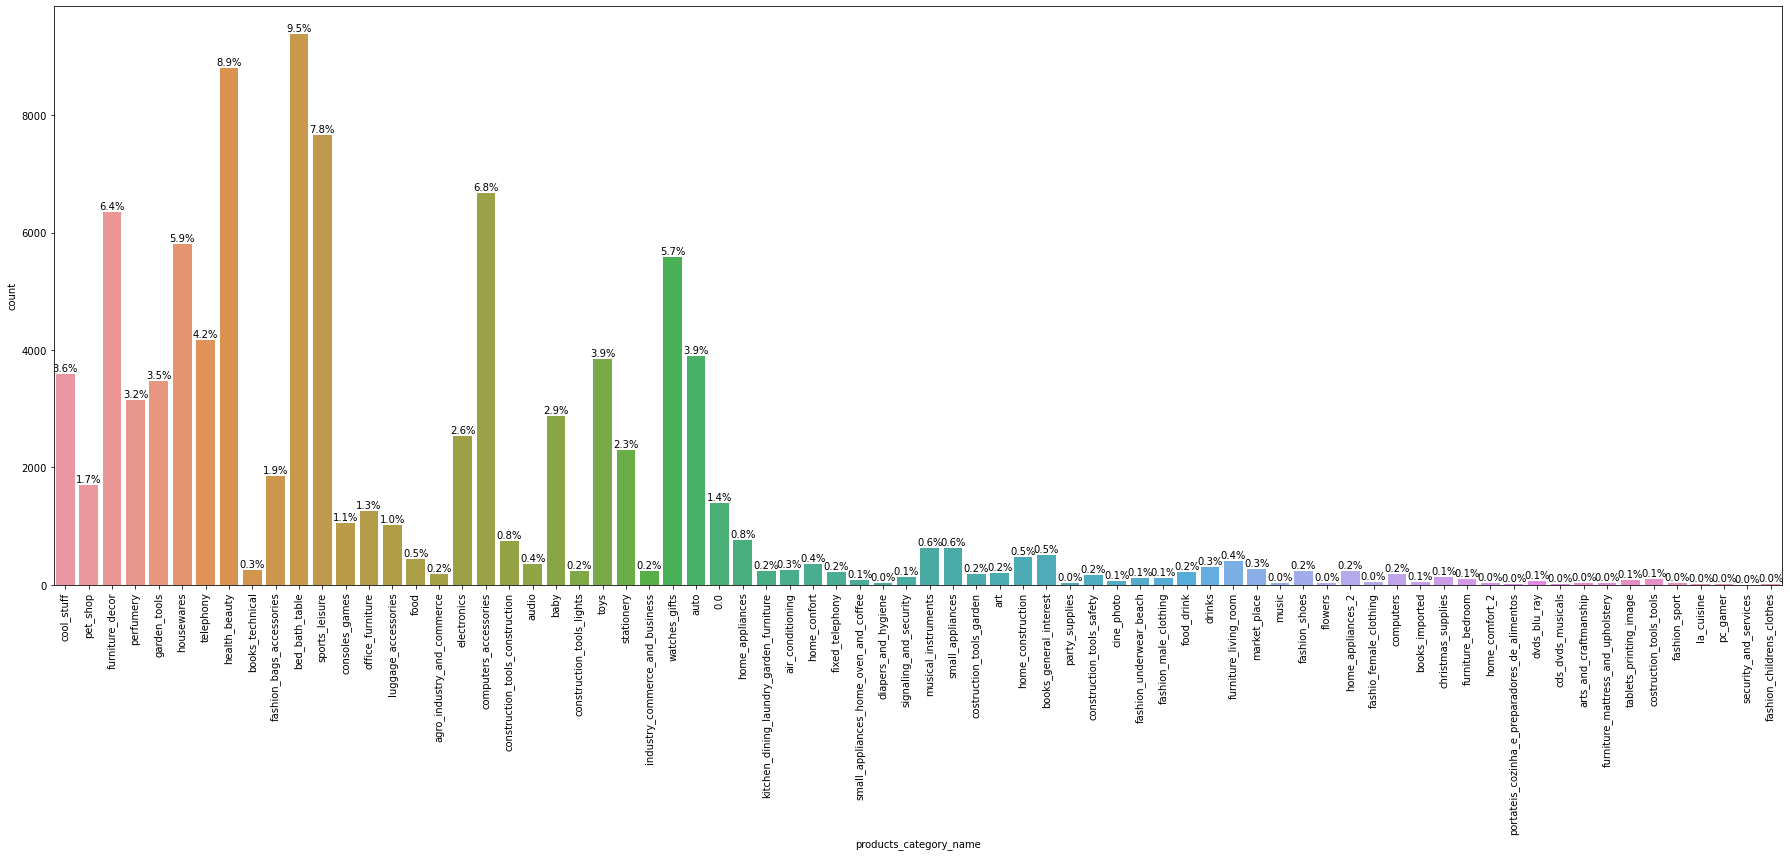

In [12]:
# Barchart visualisation of orders items category
barchart_percent(figsize=(25, 12),
                 x='products_category_name',
                 data=order_items,
                 rotation=True)

## Order payments

In [13]:
# Visualisarion of order payment dataset
order_payments = pd.read_csv('data/WRK_order_payments.csv')

In [14]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Per order I will create one feature containing the main payment type, one boolean value if a voucher have been use for the order, and calulate the main payment installment using the mode.

In [15]:
# Grouping by order and new feature calculation
order_payments = order_payments.groupby(['order_id']).apply(lambda x: pd.Series({
    'payment_type': np.array(x.loc[x['payment_value'] == x['payment_value'].max(), 'payment_type'])[0],
    'payment_installments': stats.mode(x['payment_installments'])[0].item(),
    'voucher_use': np.array(x['payment_type'].isin(['voucher'])).max()
}))

In [16]:
display(order_payments.sample(10))
print(order_payments.shape)

,payment_type,payment_installments,voucher_use
order_id,,,
31a5ceecee11538790f99ae1081e5c25,credit_card,5,False
e2047aaabab2869c1080a51c3e6b64ce,credit_card,8,False
b4f32b99da22c8263a0cf99ddd7cb55f,credit_card,6,False
d5b8231ec694904371f3efcd3450ee94,credit_card,3,False
8c4c8ec2a3220400b0dd56f270c90eea,credit_card,1,False
42c58d1a5434d2675b7835a9e8a26dda,credit_card,3,False
80039f1a61066974579290461478b384,boleto,1,False
303c1a4cb953c69bf9ad12194dc3d44d,credit_card,1,False
2d5eba84336d0f61b5cc25228d21b8ee,credit_card,10,False


(99440, 3)


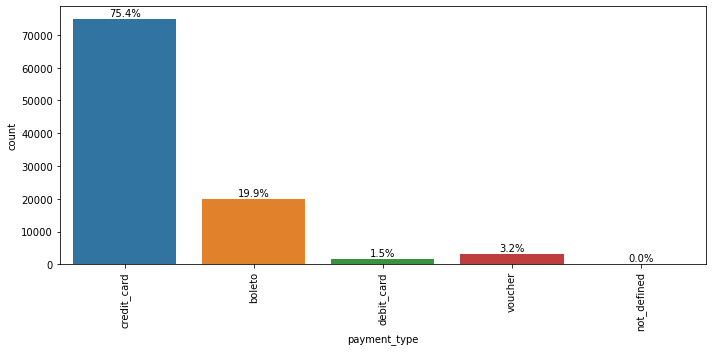

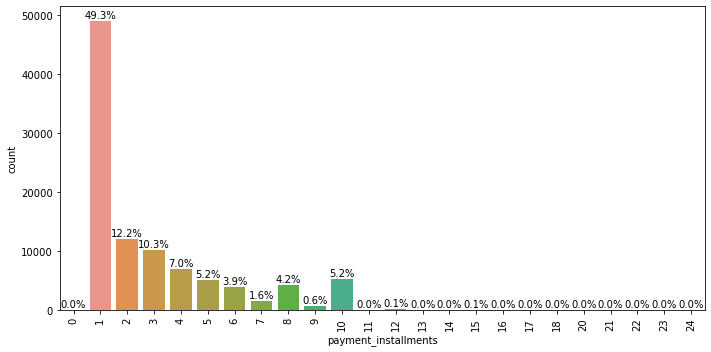

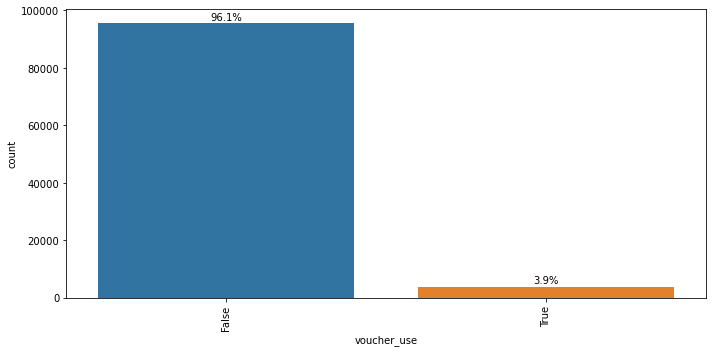

In [17]:
# Barchart visualisation of orders payment type, payment installment
# and payment voucher use

for col in order_payments.columns:
    barchart_percent(figsize=(10, 5),
                     x=col,
                     data=order_payments,
                     rotation=True)

## Orders dataset

In [18]:
# Visualisation of orders dataset
df = orders.copy()
df.head(10)

,order_id,order_purchase_timestamp,order_delivered_customer_date,tot_price,tot_freight_value,nbr_items,review_score,review_creation_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,29.99,8.72,1,4,2017-10-11 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,118.70,22.76,1,4,2018-08-08 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,159.90,19.22,1,5,2018-08-18 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,45.00,27.20,1,5,2017-12-03 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,19.90,8.72,1,5,2018-02-17 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
5,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,2017-07-26 10:57:55,147.90,27.36,1,4,2017-07-27 00:00:00,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR
6,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05-26 12:55:51,59.99,15.17,1,5,2017-05-27 00:00:00,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ
7,76c6e866289321a7c93b82b54852dc33,2017-01-23 18:29:09,2017-02-02 14:08:10,19.90,16.05,1,1,2017-02-03 00:00:00,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS
8,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29 11:55:02,2017-08-16 17:14:30,149.99,19.77,1,5,2017-08-17 00:00:00,299905e3934e9e181bfb2e164dd4b4f8,18075,sorocaba,SP
9,e6ce16cb79ec1d90b1da9085a6118aeb,2017-05-16 19:41:10,2017-05-29 11:18:31,198.00,61.06,2,1,2017-05-30 00:00:00,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ


Creation of new features in the order dataset

In [19]:
# Convert Data feartures from object to datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])

In [20]:
# Creation of a time to delivery feature
df['order_delivery_days'] = (df['order_delivered_customer_date'].dt.date - df['order_purchase_timestamp'].dt.date)
df['order_delivery_days'] = df['order_delivery_days'].dt.days

In [21]:
# Creation of a time to review feature
df['delivery_review_days'] = (df['review_creation_date'].dt.date - df['order_delivered_customer_date'].dt.date)
df['delivery_review_days'] = df['delivery_review_days'].dt.days

In [22]:
# Separation of order_purchase_timestamp into year, month, day, hours features
df['order_year'] = df['order_purchase_timestamp'].dt.year.astype('int')
df['order_month'] = df['order_purchase_timestamp'].dt.month.astype('int')
df['order_day'] = df['order_purchase_timestamp'].dt.day.astype('int')
df['order_hour'] = df['order_purchase_timestamp'].dt.hour.astype('int')

In [23]:
# Creation of total order value
df['order_tot_value'] = df['tot_price'] + df['tot_freight_value']

In [24]:
df.head(10)

,order_id,order_purchase_timestamp,order_delivered_customer_date,tot_price,tot_freight_value,nbr_items,review_score,review_creation_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_delivery_days,delivery_review_days,order_year,order_month,order_day,order_hour,order_tot_value
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,29.99,8.72,1,4,2017-10-11,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,8,1,2017,10,2,10,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,118.70,22.76,1,4,2018-08-08,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,14,1,2018,7,24,20,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,159.90,19.22,1,5,2018-08-18,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,9,1,2018,8,8,8,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,45.00,27.20,1,5,2017-12-03,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,14,1,2017,11,18,19,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,19.90,8.72,1,5,2018-02-17,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,3,1,2018,2,13,21,28.62
5,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,2017-07-26 10:57:55,147.90,27.36,1,4,2017-07-27,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,17,1,2017,7,9,21,175.26
6,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05-26 12:55:51,59.99,15.17,1,5,2017-05-27,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,10,1,2017,5,16,13,75.16
7,76c6e866289321a7c93b82b54852dc33,2017-01-23 18:29:09,2017-02-02 14:08:10,19.90,16.05,1,1,2017-02-03,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,10,1,2017,1,23,18,35.95
8,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29 11:55:02,2017-08-16 17:14:30,149.99,19.77,1,5,2017-08-17,299905e3934e9e181bfb2e164dd4b4f8,18075,sorocaba,SP,18,1,2017,7,29,11,169.76
9,e6ce16cb79ec1d90b1da9085a6118aeb,2017-05-16 19:41:10,2017-05-29 11:18:31,198.00,61.06,2,1,2017-05-30,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,13,1,2017,5,16,19,259.06


## Dataset merging

In [25]:
# Merge order, order payment and order items
df = df.merge(order_items,
              how='inner',
              on='order_id')
df = df.merge(order_payments,
              how='inner',
              on='order_id')

df.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,tot_price,tot_freight_value,nbr_items,review_score,review_creation_date,customer_unique_id,customer_zip_code_prefix,...,order_tot_value,products_category_name,products_name_lenght,products_description_lenght,products_photos_qty,order_tot_weight_g,order_tot_volume_cm3,payment_type,payment_installments,voucher_use
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,29.99,8.72,1,4,2017-10-11,7c396fd4830fd04220f754e42b4e5bff,3149,...,38.71,housewares,40.0,268.0,4.0,500.0,1976.0,voucher,1,True
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,118.70,22.76,1,4,2018-08-08,af07308b275d755c9edb36a90c618231,47813,...,141.46,perfumery,29.0,178.0,1.0,400.0,4693.0,boleto,1,False
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,159.90,19.22,1,5,2018-08-18,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,179.12,auto,46.0,232.0,1.0,420.0,9576.0,credit_card,3,False
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,45.00,27.20,1,5,2017-12-03,7c142cf63193a1473d2e66489a9ae977,59296,...,72.20,pet_shop,59.0,468.0,3.0,450.0,6000.0,credit_card,1,False
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,19.90,8.72,1,5,2018-02-17,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,28.62,stationery,38.0,316.0,4.0,250.0,11475.0,credit_card,1,False


In [26]:
# Visualisation of df shape
display(df.sample(10))
print(df.shape)

,order_id,order_purchase_timestamp,order_delivered_customer_date,tot_price,tot_freight_value,nbr_items,review_score,review_creation_date,customer_unique_id,customer_zip_code_prefix,...,order_tot_value,products_category_name,products_name_lenght,products_description_lenght,products_photos_qty,order_tot_weight_g,order_tot_volume_cm3,payment_type,payment_installments,voucher_use
32975,50d73aae647c6c12616d5bf9e6aee1c2,2017-11-21 12:44:23,2017-11-29 23:15:45,39.90,22.67,1,5,2017-11-30,aebc1c715aad58419ecb2d919f449127,74070,...,62.57,furniture_decor,53.0,187.0,1.0,900.0,2400.0,boleto,1,False
79795,77964238e13406d5f49ae1602c93b5bd,2017-09-13 13:43:13,2017-09-26 20:49:59,119.80,35.34,2,5,2017-09-27,13c5865b7b534dbe5983384eb555ed1c,37950,...,155.14,garden_tools,56.0,348.0,2.0,3100.0,39600.0,credit_card,5,False
58551,21746a2a0ab90a9d0916af6e1026fd24,2018-01-05 18:37:18,2018-01-31 15:52:26,536.00,68.76,4,5,2018-02-01,3797de5ad80619a55a3c0a8a034f5ae6,32670,...,604.76,housewares,51.0,539.0,1.0,4400.0,57536.0,credit_card,6,False
80326,b798fc527c548bfa5f069b5b29195275,2017-10-29 11:59:52,2017-11-06 14:59:01,189.80,35.83,2,5,2017-11-08,8bab3162259edfaadd1ea2e1fe7f58dc,31565,...,225.63,bed_bath_table,60.0,188.5,1.0,2650.0,6392.0,debit_card,1,False
39271,06b8cdbbc86d64ea69af76036c523827,2018-07-19 04:33:57,2018-07-20 19:21:42,137.40,44.52,6,5,2018-07-21,7cc832a90de185fa7ca3c4874d914d0b,11030,...,181.92,small_appliances,55.0,512.0,1.0,2100.0,84000.0,credit_card,2,False
13671,0eb90012b8c41dfd386552415c3b1760,2018-05-08 09:03:53,2018-05-24 21:21:29,13.77,16.41,1,5,2018-05-25,9aa2ea826dc09dd76e04f020f22af5bd,96330,...,30.18,telephony,49.0,1438.0,2.0,125.0,1045.0,credit_card,3,False
55374,0122e81ff800460e44bb9c983ff2a2fd,2018-03-16 11:58:58,2018-03-28 16:48:49,58.99,15.29,1,4,2018-03-29,89b158f7d9e3f348f6abe5234c83877b,80420,...,74.28,electronics,55.0,1040.0,4.0,200.0,880.0,boleto,1,False
88146,0d88b2392b18e01d23c582190ada0f24,2018-01-11 21:47:10,2018-02-02 11:15:46,69.90,16.12,1,5,2018-02-03,e9b82fe0de63859e8606d95a923f0263,18440,...,86.02,furniture_decor,44.0,903.0,6.0,2600.0,15000.0,boleto,1,False
6699,2fd35ca971609b8f8f878d87262e6fbd,2017-07-26 10:05:30,2017-08-04 17:57:36,35.00,15.10,1,5,2017-08-05,b60d47f5f8de9fbc6cf1c1fedeab9f0e,24230,...,50.10,consoles_games,47.0,458.0,2.0,150.0,576.0,boleto,1,False
75776,006cba07f62f921fe4f58365bde2b2eb,2017-08-14 20:28:45,2017-08-18 19:57:57,69.99,11.99,1,5,2017-08-19,daec6ee742b2b2ce14fcb41bd844045a,15390,...,81.98,toys,26.0,855.0,2.0,500.0,2268.0,credit_card,2,False


(96335, 28)


In [27]:
# Visualisation of transaction timeframe
print('Transactions timeframe from {} to {}'.format(df['order_purchase_timestamp'].min(),
                                                    df['order_purchase_timestamp'].max()))

Transactions timeframe from 2016-10-03 09:44:50 to 2018-08-29 15:00:37


## Customer city information-feature engineering

In this dataset we have information on customer localisation. However the city, state and zip code are not very interresting information so I check in Kaggle and I found a dataset containing cities demographic info - https://www.kaggle.com/crisparada/brazilian-cities?select=BRAZIL_CITIES.csv. Wiht this I will be able to have the number of inhabitant per city which is a more interesting info as you can use it to cluster client into small, medium or big city.

In [28]:
# Loading cities info dataset
cities = pd.read_csv('data/BRAZIL_CITIES.csv', sep=';')

In [29]:
cities.head()

,CITY,STATE,CAPITAL,IBGE_RES_POP,IBGE_RES_POP_BRAS,IBGE_RES_POP_ESTR,IBGE_DU,IBGE_DU_URBAN,IBGE_DU_RURAL,IBGE_POP,...,Pu_Bank,Pr_Assets,Pu_Assets,Cars,Motorcycles,Wheeled_tractor,UBER,MAC,WAL-MART,POST_OFFICES
0,Abadia De Goiás,GO,0,6876.0,6876.0,0.0,2137.0,1546.0,591.0,5300.0,...,NaN,NaN,NaN,2158.0,1246.0,0.0,NaN,NaN,NaN,1.0
1,Abadia Dos Dourados,MG,0,6704.0,6704.0,0.0,2328.0,1481.0,847.0,4154.0,...,NaN,NaN,NaN,2227.0,1142.0,0.0,NaN,NaN,NaN,1.0
2,Abadiânia,GO,0,15757.0,15609.0,148.0,4655.0,3233.0,1422.0,10656.0,...,1.0,33724584.0,67091904.0,2838.0,1426.0,0.0,NaN,NaN,NaN,3.0
3,Abaeté,MG,0,22690.0,22690.0,0.0,7694.0,6667.0,1027.0,18464.0,...,2.0,44974716.0,371922572.0,6928.0,2953.0,0.0,NaN,NaN,NaN,4.0
4,Abaetetuba,PA,0,141100.0,141040.0,60.0,31061.0,19057.0,12004.0,82956.0,...,4.0,76181384.0,800078483.0,5277.0,25661.0,0.0,NaN,NaN,NaN,2.0


In [30]:
# Keep only variable of interested
cities = cities.loc[:, ['CITY', 'STATE', 'IBGE_RES_POP']]

In [31]:
# Function to clean string columns
import unidecode


def pretty_string(column):
    column_space = ' '.join(column.split())
    return unidecode.unidecode(column_space.lower())

In [32]:
# Clean city name
cities['CITY'] = cities['CITY'].apply(pretty_string)

In [33]:
# Merge df and cities dataset
df = df.merge(cities,
              how='inner',
              left_on=['customer_city', 'customer_state'],
              right_on=['CITY', 'STATE'])

In [34]:
df.columns

Index(['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date',
       'tot_price', 'tot_freight_value', 'nbr_items', 'review_score',
       'review_creation_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_delivery_days', 'delivery_review_days', 'order_year',
       'order_month', 'order_day', 'order_hour', 'order_tot_value',
       'products_category_name', 'products_name_lenght',
       'products_description_lenght', 'products_photos_qty',
       'order_tot_weight_g', 'order_tot_volume_cm3', 'payment_type',
       'payment_installments', 'voucher_use', 'CITY', 'STATE', 'IBGE_RES_POP'],
      dtype='object')

<AxesSubplot:>

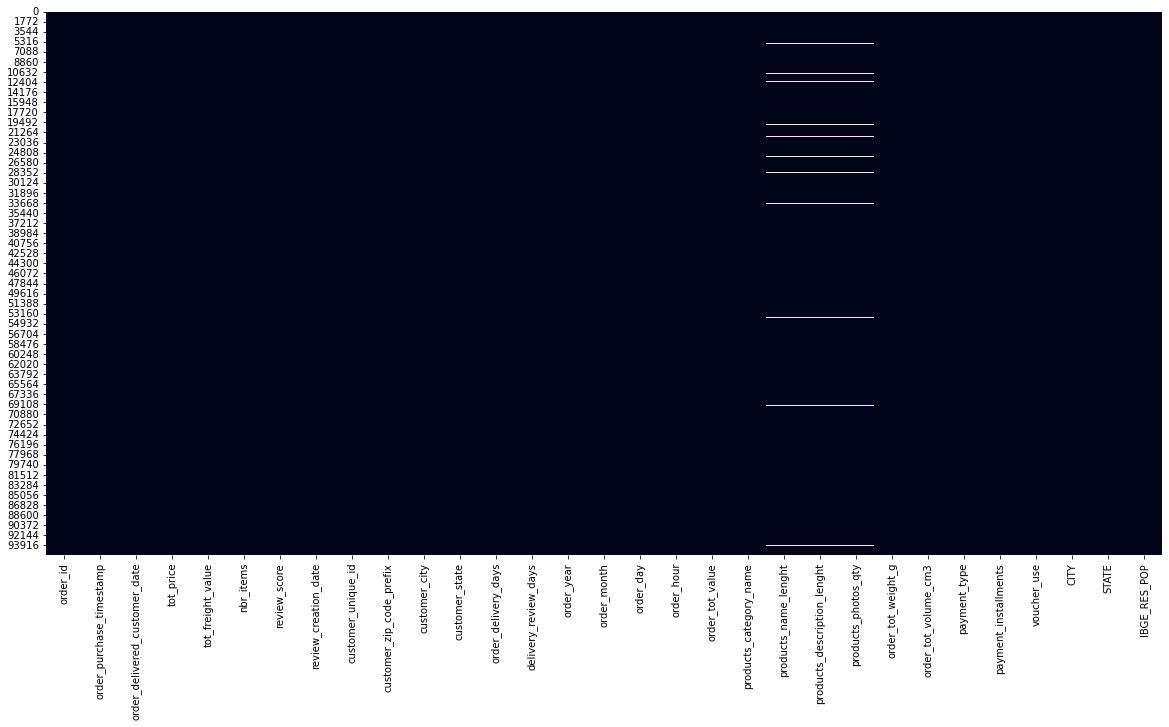

In [35]:
# Visualise Nan values
plt.figure(figsize=(20, 10))
sns.heatmap(df.isna(), cbar=False)

In [36]:
# Export order base dataset
df.to_csv('DRV_orders.csv')

# Client based dataset creation

We now have a dataset which is based on the order. However to do a client segmentation we need to have a unique client based dataset. So it the next step we are going to create a dataset with information about client. This order based dataset could be use in an other type of study. However here, for the exploratory analysis and the clustering I will use the customer based one because it match better with the problematic.

## Feature engineering

In [37]:
# Create snapshot date
snapshot_date = df['order_purchase_timestamp'].max() + timedelta(days=1)
print(snapshot_date)

2018-08-30 15:00:37


In [38]:
# Grouping by customer and feature creation
df_client = df.groupby(['customer_unique_id']).apply(lambda x: pd.Series({
    'last_purchase_date': x['order_purchase_timestamp'].max(),
    'recency': (snapshot_date - x['order_purchase_timestamp'].max()).days,
    'frequency': x['order_id'].count(),
    'monetary_value': x['order_tot_value'].sum(),
    'mean_order_delivery_days': x['order_delivery_days'].mean(),
    'mean_order_volume_cm3': x['order_tot_volume_cm3'].max(),
    'avg_review_score': x['review_score'].mean(),
    'main_product_category': stats.mode(x['products_category_name'])[0].item(),
    'main_payment_type': stats.mode(x['payment_type'])[0].item(),
    'p_voucher_use': x['voucher_use'].sum() / x['order_id'].count(),
    'mean_payment_installments': x['payment_installments'].mean(),
    'customer_city_size': x['IBGE_RES_POP'].mean()
}))

In [39]:
nbr_client = df_client.shape[0]

In [40]:
# Export full client base dataset
df_client.to_csv('data/DRV_customer_clustering_all.csv')

The clustering is on client which have done at least 2 purchases. Olist told use that it represente ~ 3% of the full dataset.

In [41]:
# Keep only client with at least 2 purchases
df_client = df_client[df_client['frequency'] > 1]

In [42]:
# Check if we have the good proportion of client for exploration and modeling
percentOfUseClient = df_client.shape[0] / nbr_client * 100
print(percentOfUseClient)

3.0774411505914814


In [43]:
df_client.head()

,last_purchase_date,recency,frequency,monetary_value,mean_order_delivery_days,mean_order_volume_cm3,avg_review_score,main_product_category,main_payment_type,p_voucher_use,mean_payment_installments,customer_city_size
customer_unique_id,,,,,,,,,,,,
000bfa1d2f1a41876493be685390d6d3,2017-09-29 14:46:58,335,2,93.70,14.0,2646.0,4.5,fashion_bags_accessories,credit_card,0.0,4.0,419400.0
004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,228,2,354.37,6.5,33792.0,5.0,cool_stuff,credit_card,0.0,2.0,796257.0
00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,88,2,123.25,17.5,3960.0,4.0,electronics,credit_card,0.0,1.0,2570160.0
00cc12a6d8b578b8ebd21ea4e2ae8b27,2017-03-21 19:25:23,526,4,252.40,6.5,23625.0,4.0,bed_bath_table,boleto,0.0,1.0,11253503.0
011575986092c30523ecb71ff10cb473,2018-04-18 21:58:08,133,2,214.90,13.5,13500.0,3.5,musical_instruments,credit_card,0.0,1.5,2375151.0


In [44]:
df_client.shape

(2833, 12)

# Exploratory analysis

In [45]:
# Calculated the missing rate of a column
def filling_factor(df):
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']
    missing_df['filling_factor'] = \
        (df.shape[0] - missing_df['missing_count']) / df.shape[0] * 100
    missing_df = \
        missing_df.sort_values('filling_factor').reset_index(drop=True)
    return missing_df

In [46]:
filling_factor(df_client)

,column_name,missing_count,filling_factor
0,last_purchase_date,0,100.0
1,recency,0,100.0
2,frequency,0,100.0
3,monetary_value,0,100.0
4,mean_order_delivery_days,0,100.0
5,mean_order_volume_cm3,0,100.0
6,avg_review_score,0,100.0
7,main_product_category,0,100.0
8,main_payment_type,0,100.0
9,p_voucher_use,0,100.0


<AxesSubplot:>

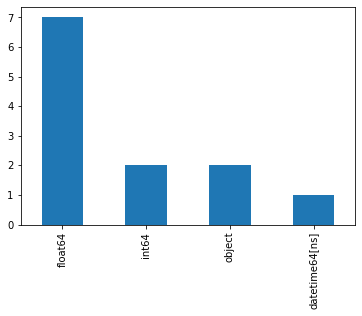

In [47]:
# Analyse of feature type
df_client.dtypes.value_counts().plot(kind='bar')

## Univariate analysis

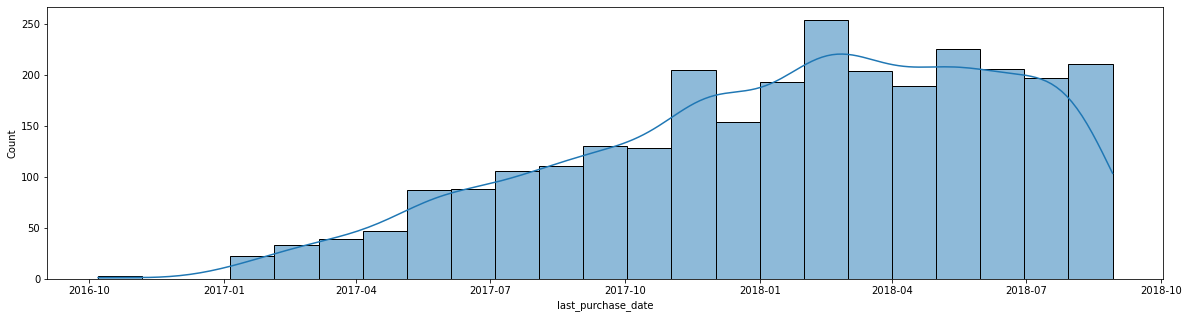

In [48]:
# Histogram of last purchase date
plt.figure(figsize=(20, 5))
sns.histplot(x=df_client['last_purchase_date'],
             data=df_client,
             kde=True)
plt.show()

In [49]:
# function exploration continous variable
def EDA_continous(data):
    df_continous = data.select_dtypes(exclude=['object', 'datetime']).columns

    for col in df_continous:
        fig = plt.figure(figsize=(20, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(x=data[col],
                     data=data,
                     kde=True)

        plt.subplot(1, 2, 2)
        sns.boxplot(x=data[col],
                    data=data)
        fig.tight_layout(pad=0.8)

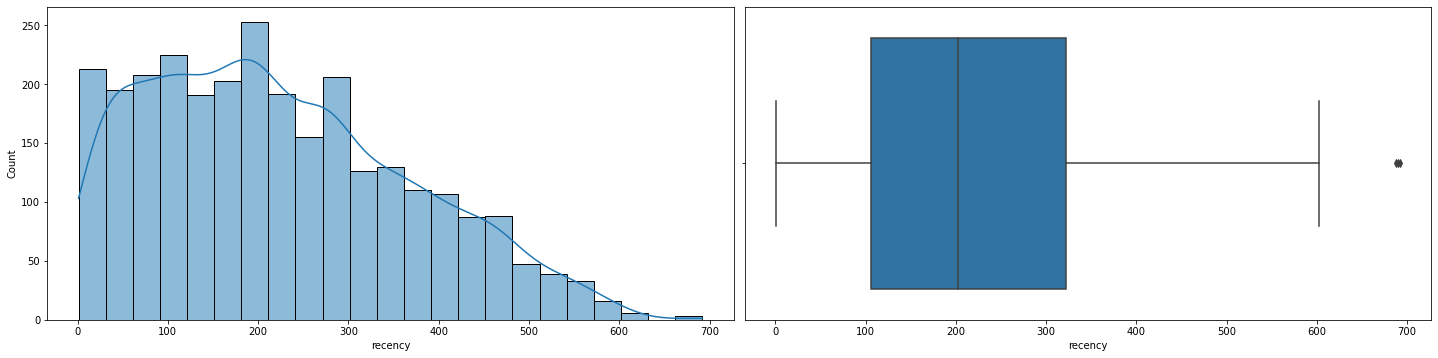

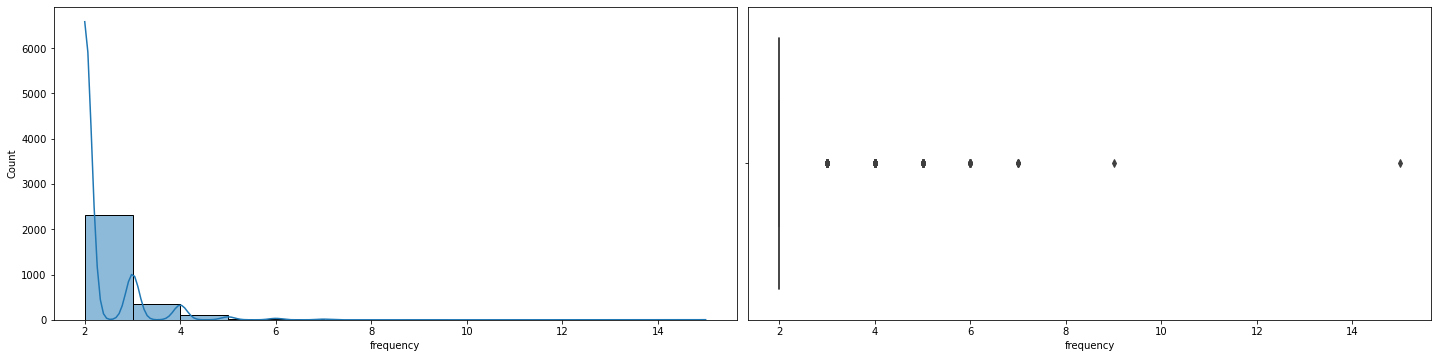

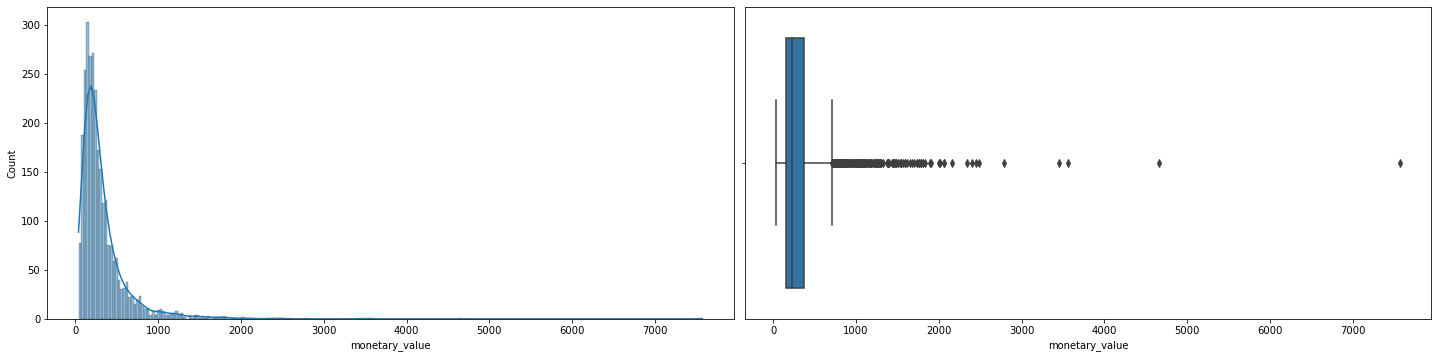

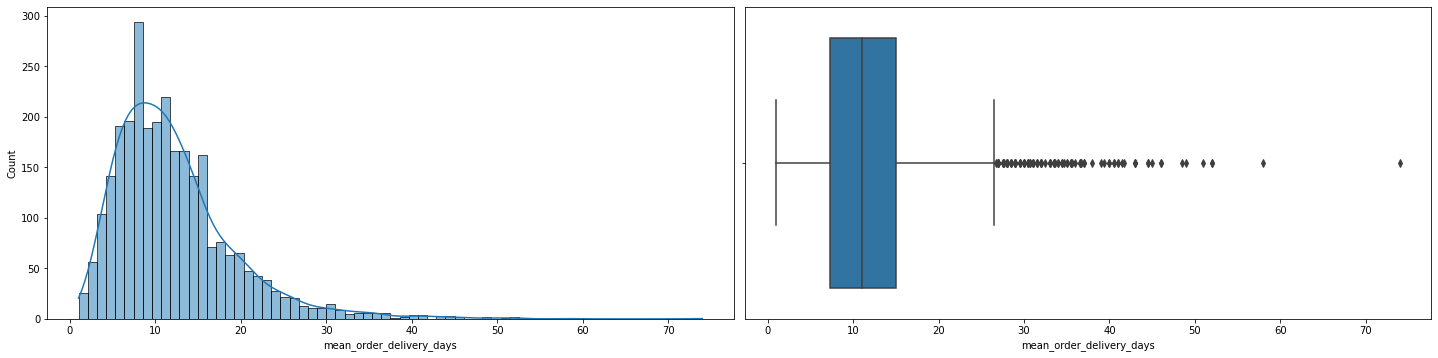

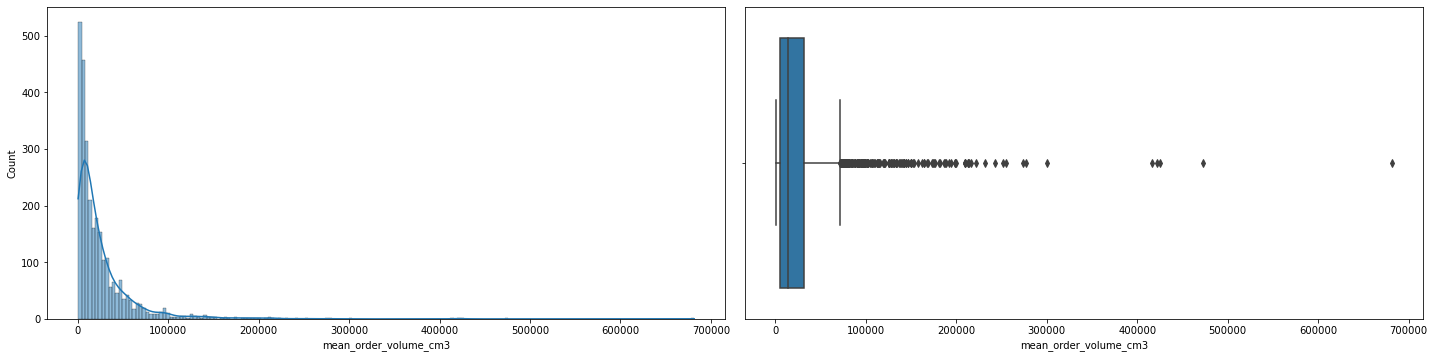

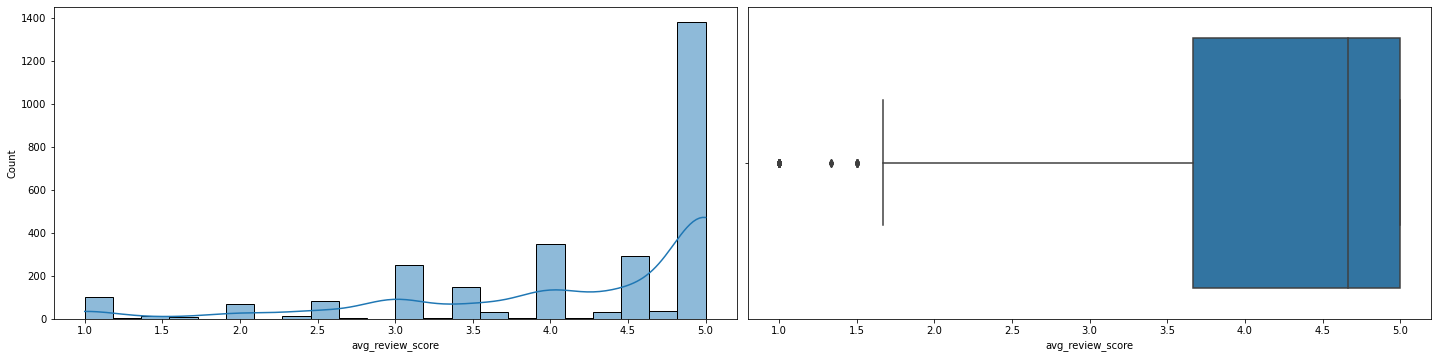

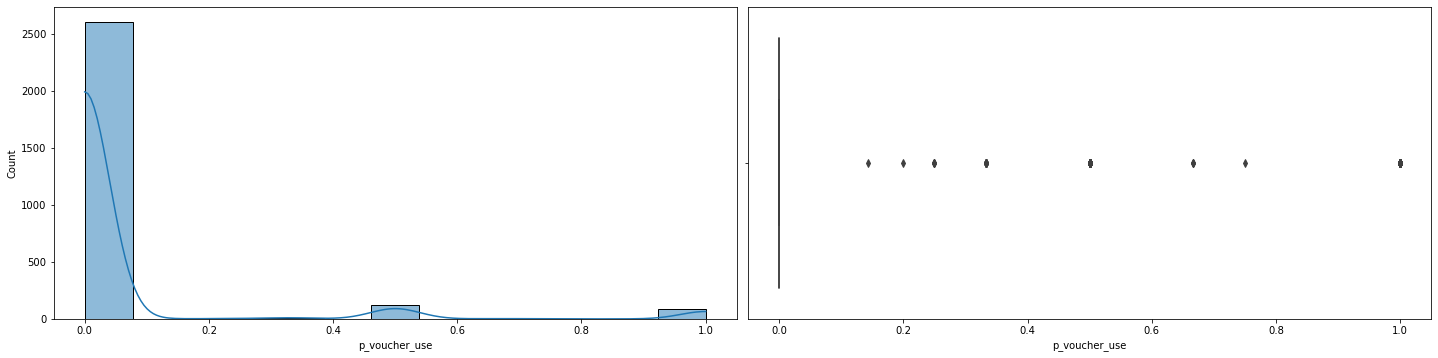

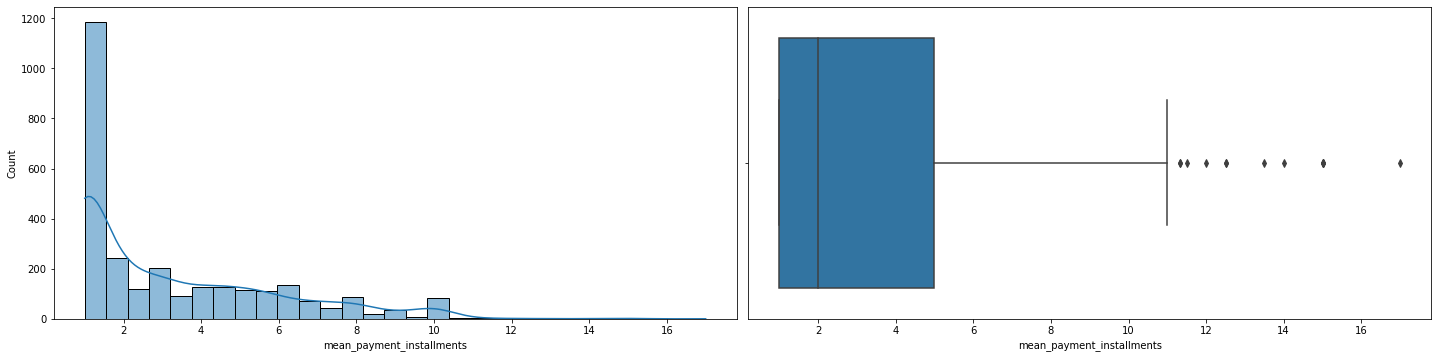

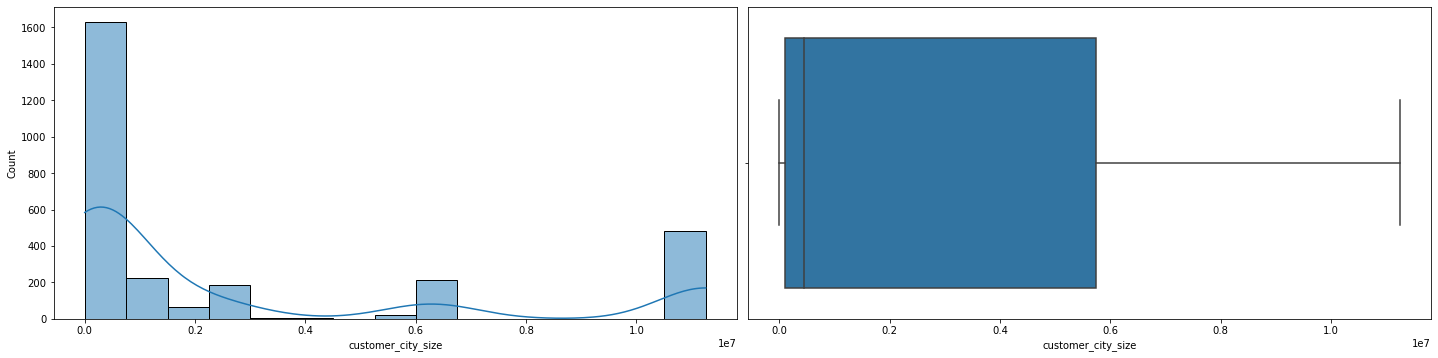

In [50]:
EDA_continous(df_client)

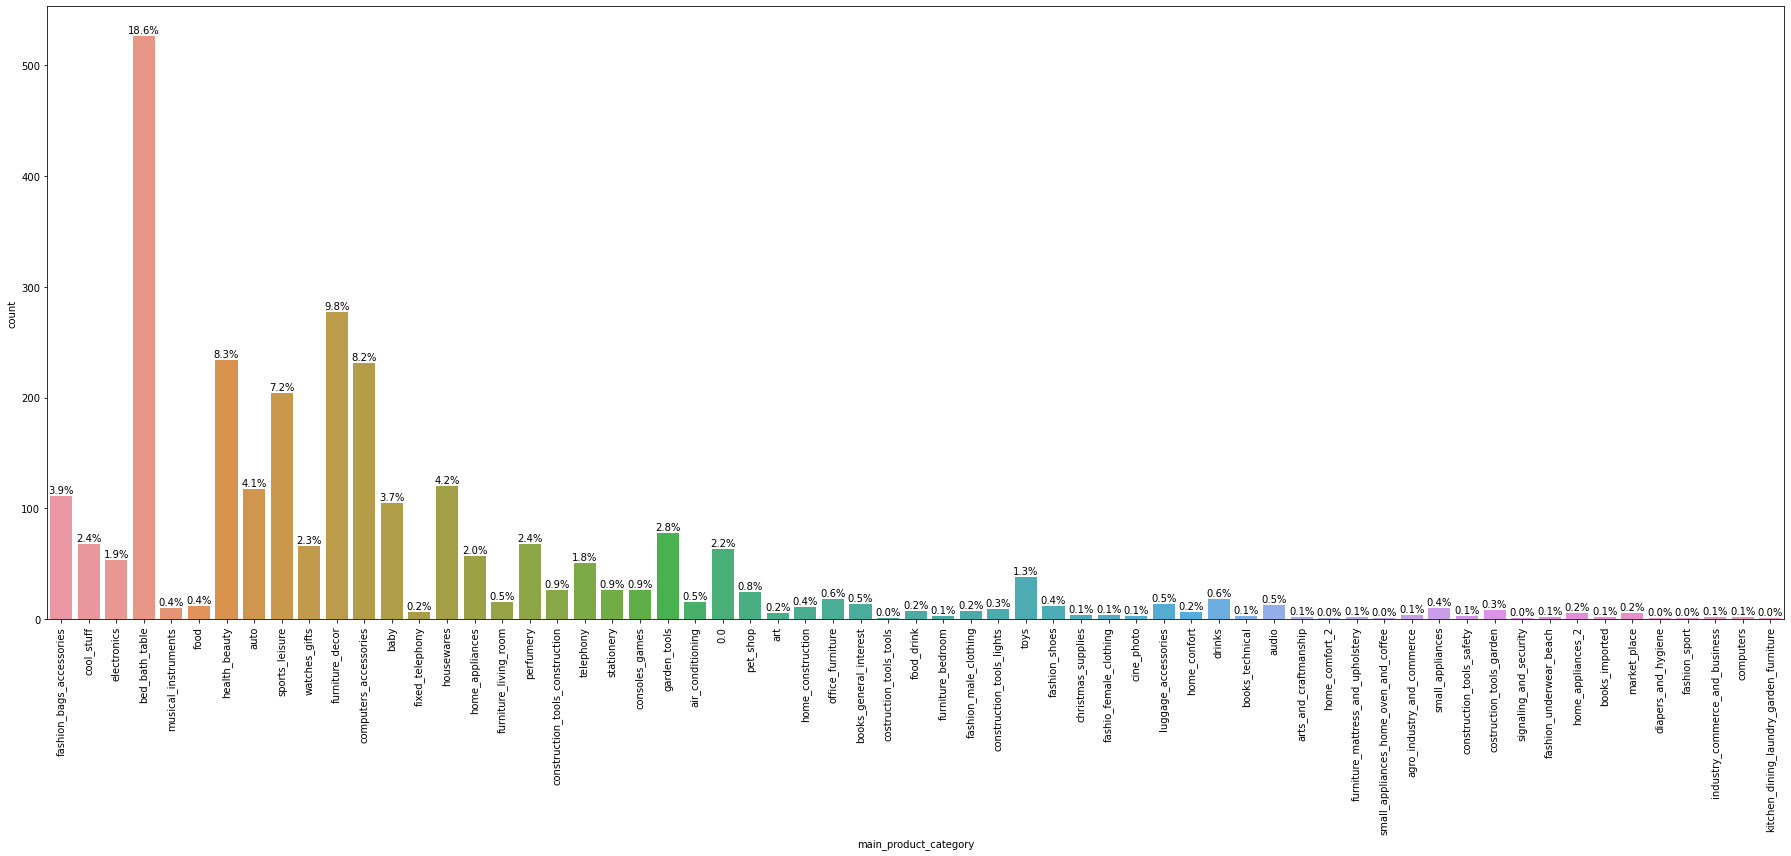

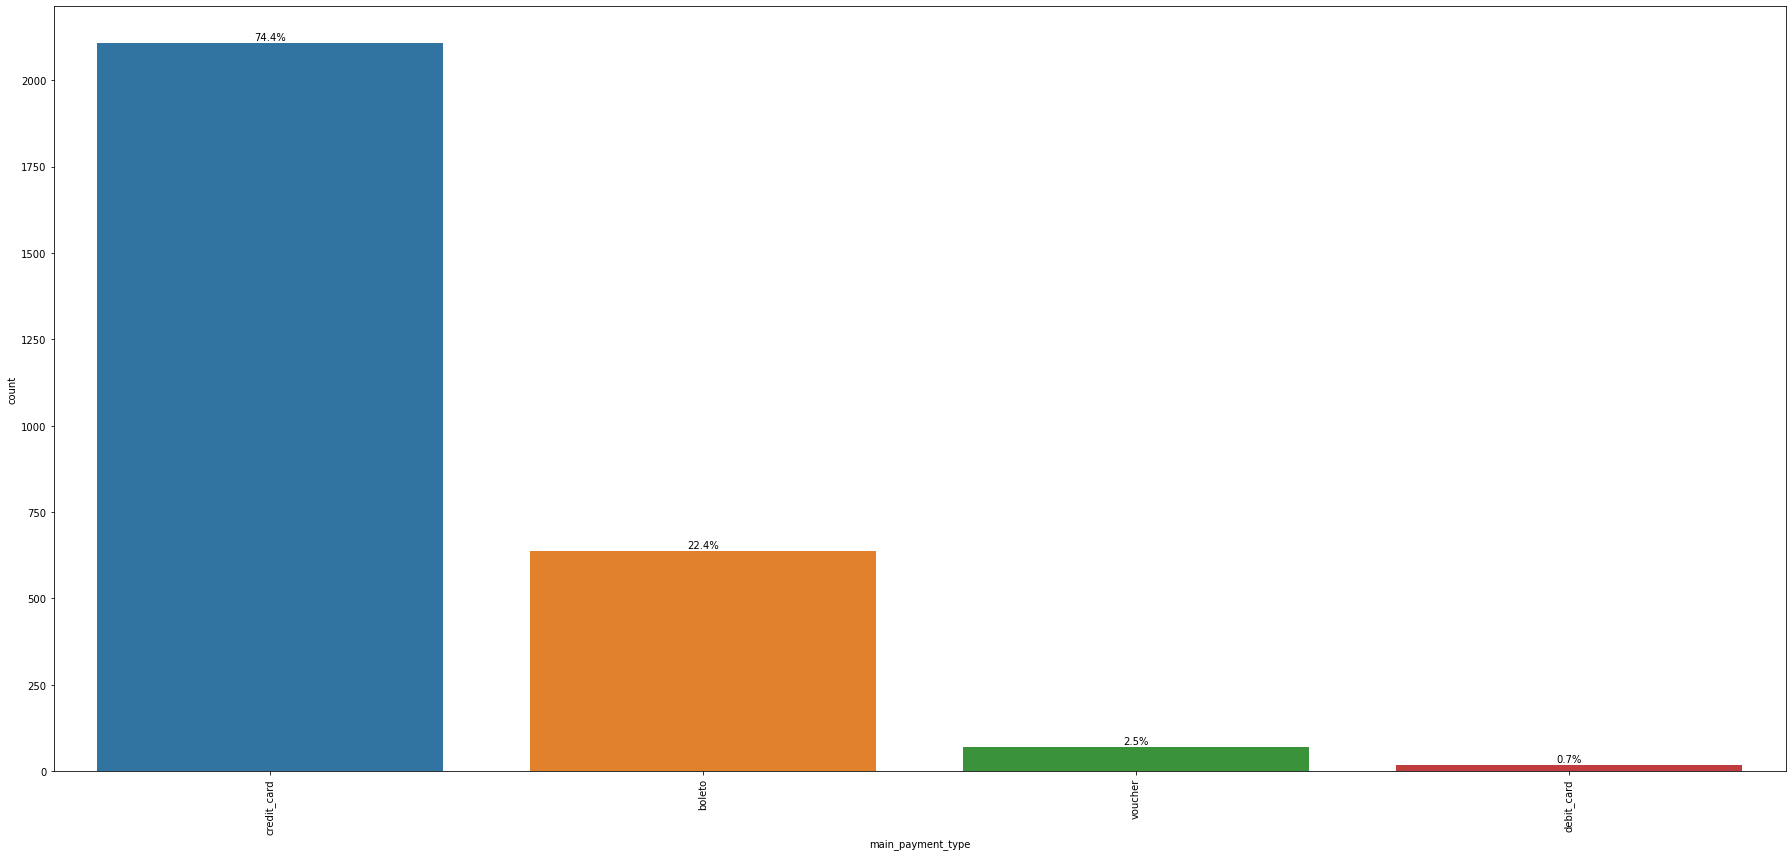

In [51]:
# Bar chart of categorical features
for col in df_client.select_dtypes('object'):
    barchart_percent(figsize=(25, 12),
                     x=col,
                     data=df_client,
                     rotation=True)

## Bivariate analysis

### Numerical vs Numerical

In [52]:
# Correlation matrix between all numerical variables
corr = df_client.corr('spearman')
corr.style.background_gradient(cmap='coolwarm')

,recency,frequency,monetary_value,mean_order_delivery_days,mean_order_volume_cm3,avg_review_score,p_voucher_use,mean_payment_installments,customer_city_size
recency,1.000000,0.098313,-0.033590,0.149317,0.011496,-0.034780,-0.008388,0.059855,-0.042738
frequency,0.098313,1.000000,0.271219,0.068910,0.034049,0.006127,0.000038,0.013106,-0.002396
monetary_value,-0.033590,0.271219,1.000000,0.144607,0.411971,-0.047874,-0.055673,0.283722,-0.044933
mean_order_delivery_days,0.149317,0.068910,0.144607,1.000000,0.036707,-0.211401,0.025824,0.084107,-0.210797
mean_order_volume_cm3,0.011496,0.034049,0.411971,0.036707,1.000000,-0.028686,-0.011796,0.163680,-0.047818
avg_review_score,-0.034780,0.006127,-0.047874,-0.211401,-0.028686,1.000000,-0.022175,-0.005730,-0.035040
p_voucher_use,-0.008388,0.000038,-0.055673,0.025824,-0.011796,-0.022175,1.000000,-0.182082,0.006522
mean_payment_installments,0.059855,0.013106,0.283722,0.084107,0.163680,-0.005730,-0.182082,1.000000,-0.090455
customer_city_size,-0.042738,-0.002396,-0.044933,-0.210797,-0.047818,-0.035040,0.006522,-0.090455,1.000000


In [53]:
# Spearman Correlation, pvalue for all features vs target
for row in corr.index:
    for col in corr.columns:
        if (row != col) and (corr.loc[row, col] > 0.5) or (corr.loc[row, col] < -0.5):
            spearman_coef, p_value = stats.spearmanr(np.array(df_client[row]), np.array(df_client[col]))
            if p_value < 0.05:
                print(f'{row :-<5} {col:-<50} {corr.loc[row, col]} {p_value} ')

There is no strong correlation between continous variable. Instead for Monetary value, avg_order_value and max_order_value whihc is obvious.

### Categorical vs Categorical

In [54]:
# creation of contengency table
X = "main_product_category"
Y = "main_payment_type"
cont = df_client[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len).fillna(0).copy().astype(int)
cont

main_payment_type,boleto,credit_card,debit_card,voucher
main_product_category,,,,
0.0,10,52,0,1
agro_industry_and_commerce,1,3,0,0
air_conditioning,5,9,0,1
art,1,4,0,0
arts_and_craftmanship,0,1,1,0
...,...,...,...,...
sports_leisure,47,154,0,3
stationery,3,21,0,2
telephony,10,38,2,1


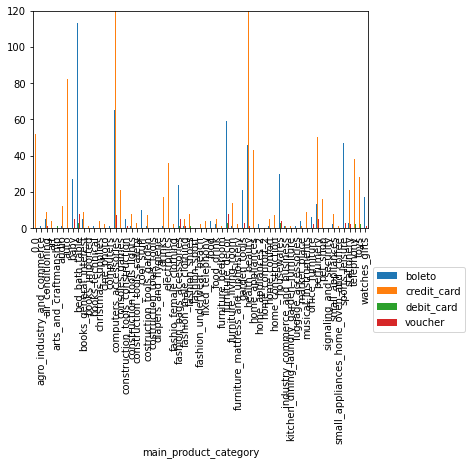

In [55]:
# Barchart contengency table
cont.plot(kind='bar')
plt.ylim(0, 120)
plt.legend(bbox_to_anchor=(1, -.5), loc='lower left', ncol=1)

In [56]:
# Khi2 test between nutriscore grade and pnns_goups_1
st_chi2, st_p, st_dof, st_exp = stats.chi2_contingency(cont)
print(st_p)

0.003647598096635262


### Numerical vs categorical

In [57]:
def EDA_boxplot(figsize, data, y):
    plt.figure(figsize=(figsize))
    i = 0
    for col in data.select_dtypes(exclude=['object', 'datetime']).columns:
        plt.subplot(12, 2, i+1)
        sns.boxplot(data=data,
                    x=col,
                    y=y,
                    orient="h",
                    showfliers=False,
                    palette="viridis")
        i += 1
    plt.tight_layout(pad=1)
    plt.show()

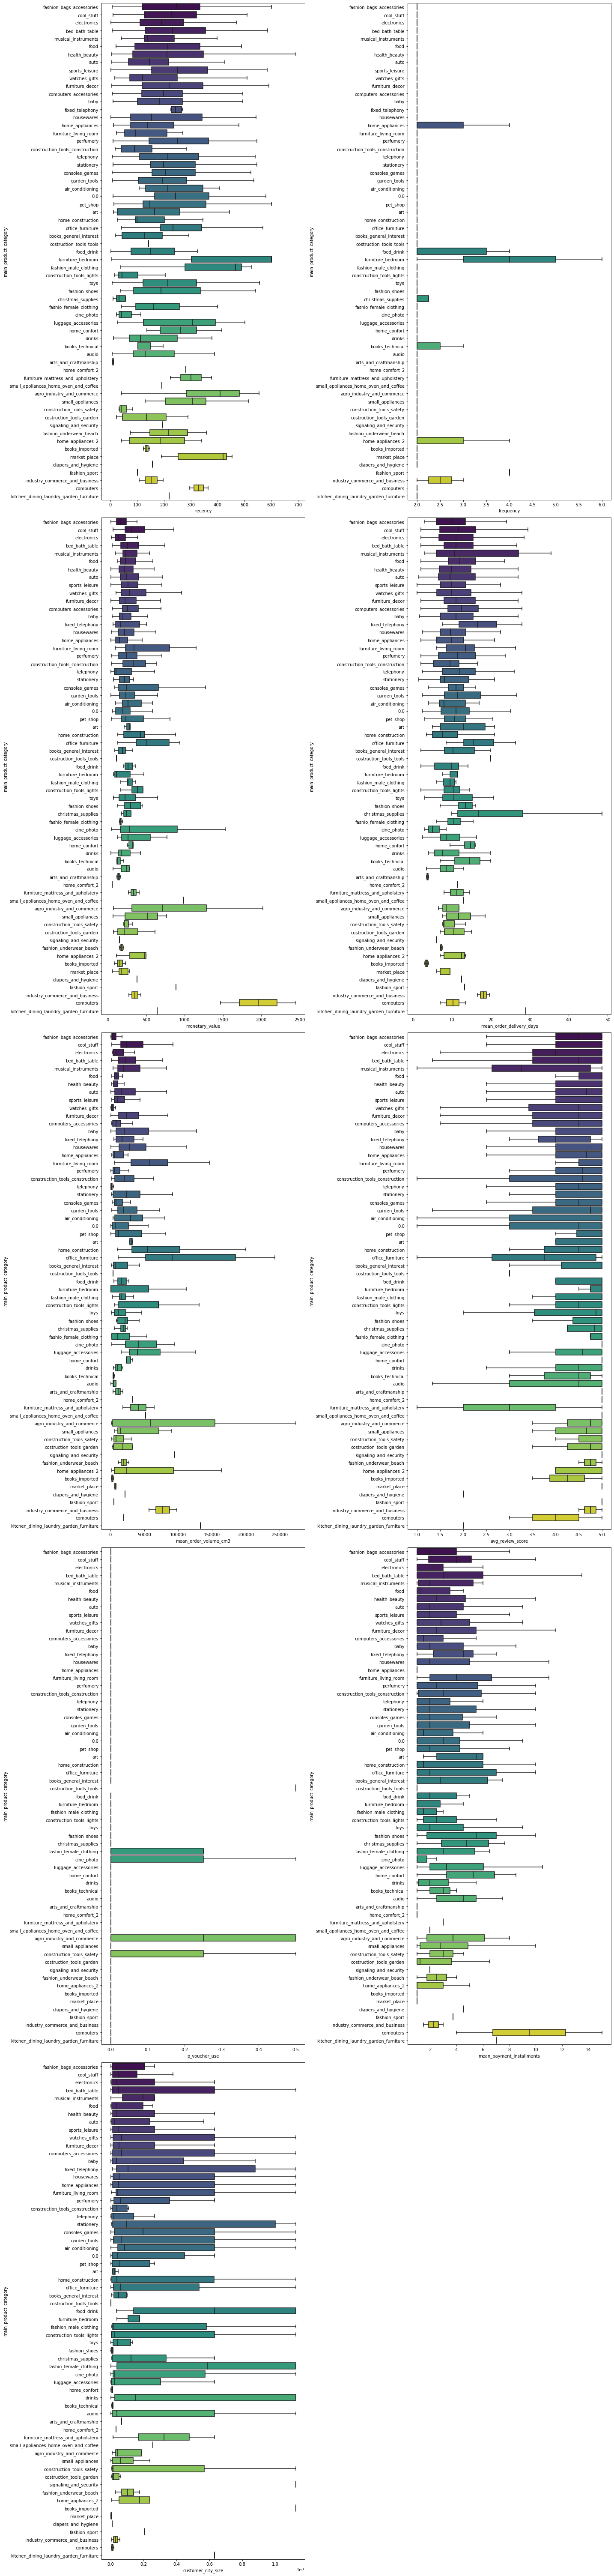

In [58]:
# Product type vs numerical features
EDA_boxplot(figsize=(20, 200),
            data=df_client,
            y="main_product_category")

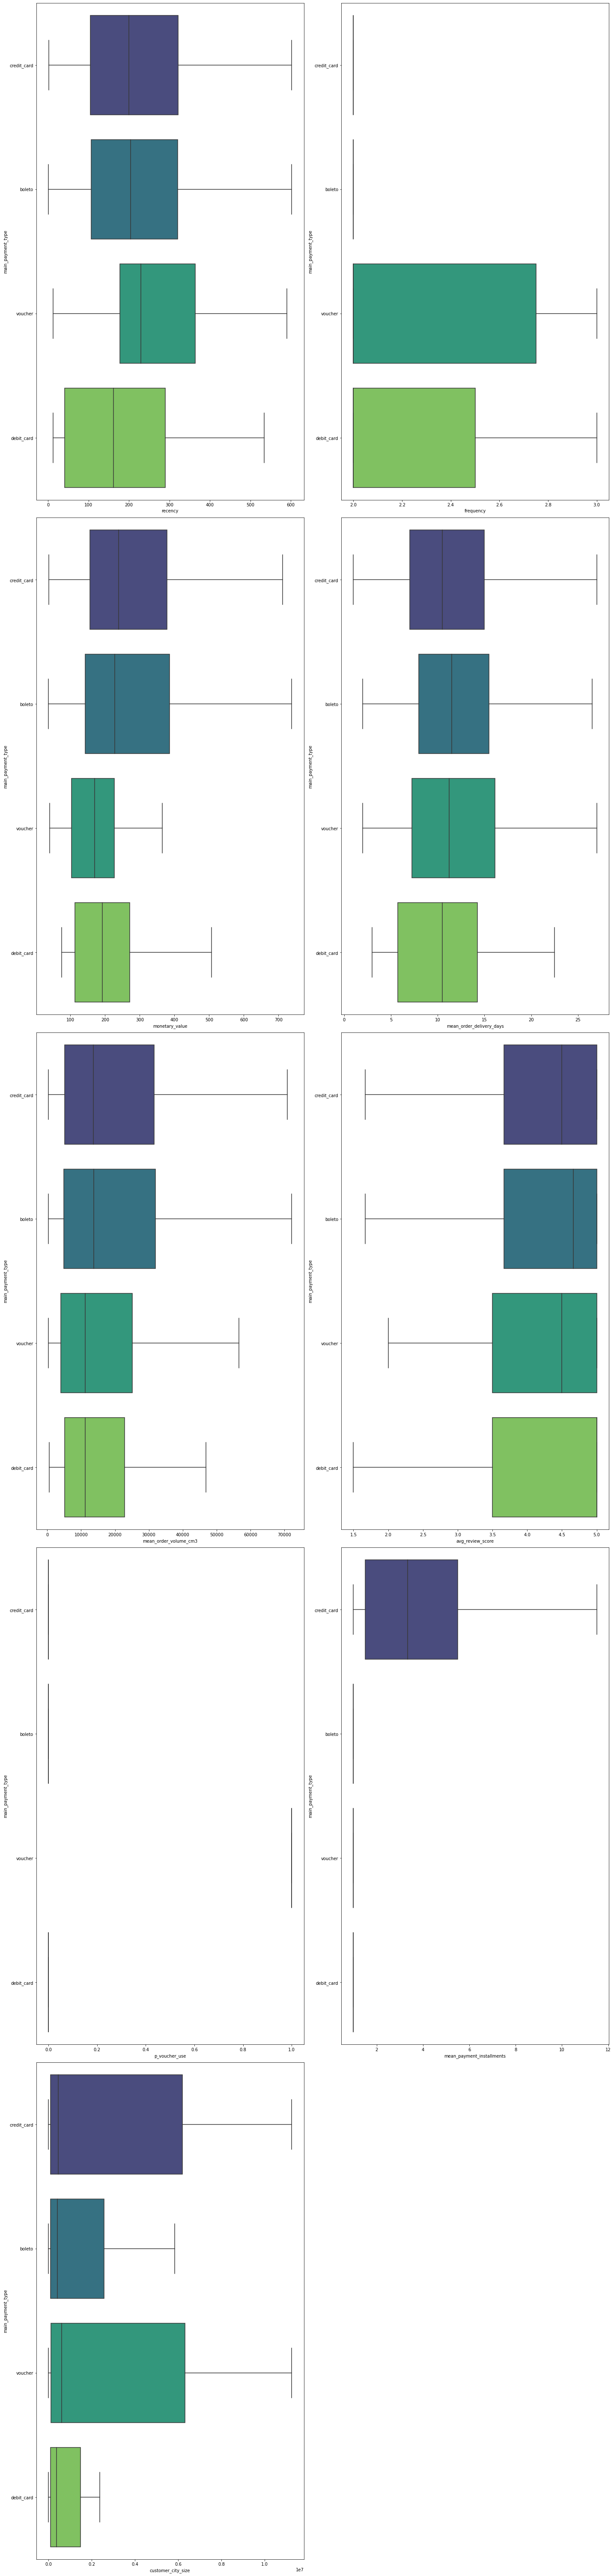

In [59]:
# Payment type vs numerical features
EDA_boxplot(figsize=(20, 200),
            data=df_client,
            y="main_payment_type")

In [60]:
# ANOVA between numerical features and categorical features
import statsmodels.api as sm
from statsmodels.formula.api import ols

for col in df_client.select_dtypes(exclude=['object', 'datetime']).columns:
    model = ols(f'{col}~C(main_product_category)', data=df_client).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(f' {col}')
    display(aov_table)
    print('\n')

for col in df_client.select_dtypes(exclude=['object', 'datetime']).columns:
    model = ols(f'{col}~C(main_payment_type)', data=df_client).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    print(f' {col}')
    display(aov_table)
    print('\n')

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# Export client base dataset
df_client.to_csv('data/DRV_customer_clustering.csv')